In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
with open("Cleaned_LoanData.csv", "r", encoding='utf-8') as f:
    line_count = sum(1 for line in f)
print("Lines in file (including header):", line_count)


Lines in file (including header): 290263


In [ ]:
df = pd.read_csv("Cleaned_LoanData.csv", sep=None, engine='python', encoding='utf-8')
print(df.shape)


(290262, 42)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290262 entries, 0 to 290261
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CreditScore                 290262 non-null  int64  
 1   FirstPaymentDate            290262 non-null  object 
 2   FirstTimeHomebuyer          290262 non-null  float64
 3   MaturityDate                290262 non-null  object 
 4   MIP                         290262 non-null  int64  
 5   Units                       290262 non-null  int64  
 6   OCLTV                       290262 non-null  int64  
 7   DTI                         290262 non-null  int64  
 8   OrigUPB                     290262 non-null  int64  
 9   LTV                         290262 non-null  int64  
 10  OrigInterestRate            290262 non-null  float64
 11  PropertyState               290262 non-null  object 
 12  OrigLoanTerm                290262 non-null  int64  
 13  NumBorrowers  

In [ ]:
# Drop leaky features
leaky_features = ['EverDelinquent', 'DelinquencyCategory_1', 'DelinquencyCategory_0', 'MonthsDelinquent']
df.drop(columns=leaky_features, inplace=True)

In [ ]:
# Define target and features
X = df.drop(columns='DelinquencyFlag')
y = df['DelinquencyFlag']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Scale and fit the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate on train and test
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.9460
Test Accuracy: 0.9454


In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split

# Sample 20% of training data for faster tuning
X_sampled, _, y_sampled, _ = train_test_split(X_train, y_train, train_size=0.2, stratify=y_train, random_state=42)

# Simplified grid: only L2 regularization with varying strength
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10]
}

# Grid Search with 3-fold CV and parallel jobs
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit grid search on sampled training data
grid_search.fit(X_sampled, y_sampled)

# Save best model
best_model = grid_search.best_estimator_

# Output best parameters
print(" Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best Parameters: {'logreg__C': 1}


In [ ]:
# Retrain best model on the full training data
best_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=1, random_state=42, solver='liblinear'))])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Train Accuracy: 0.9460098445796674
Test Accuracy: 0.9454119511480888

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     46585
           1       0.95      0.76      0.85     11468

    accuracy                           0.95     58053
   macro avg       0.95      0.88      0.91     58053
weighted avg       0.95      0.95      0.94     58053

Confusion Matrix:
 [[46156   429]
 [ 2740  8728]]


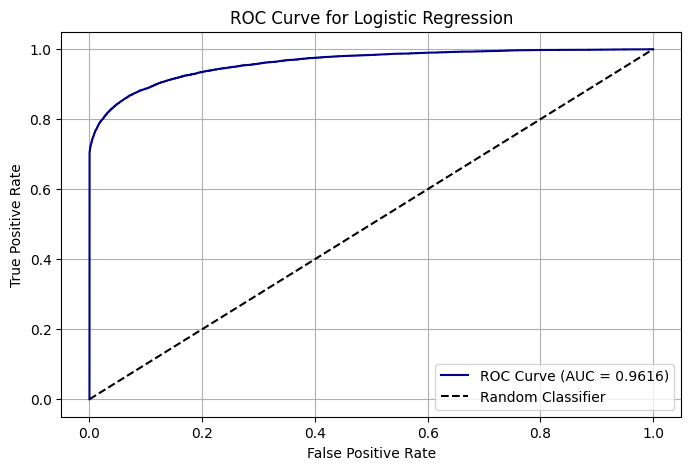

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probability predictions
y_proba = best_model.predict_proba(X_test)[:, 1]

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color='darkblue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


# **Linear Discriminant Analysis (LDA)**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, make_scorer
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

In [ ]:
#Model Training (Assumes X_train, X_test, y_train, y_test are ready)

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_test)

In [ ]:
#Step 2: Model Evaluation
accuracy = accuracy_score(y_test, y_pred_lda)
precision = precision_score(y_test, y_pred_lda, average='weighted')
recall = recall_score(y_test, y_pred_lda, average='weighted')
f1 = f1_score(y_test, y_pred_lda, average='weighted')
error_rate = 1 - accuracy

print("🔍 LDA Model Evaluation (Train-Test Split):")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-Score: {f1:.4f}")
print(f"❌ Error Rate: {error_rate:.4f}")

🔍 LDA Model Evaluation (Train-Test Split):
✅ Accuracy: 0.9410
📌 Precision: 0.9450
📌 Recall: 0.9410
📌 F1-Score: 0.9368
❌ Error Rate: 0.0590


In [ ]:
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_lda))



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     46585
           1       1.00      0.70      0.82     11468

    accuracy                           0.94     58053
   macro avg       0.97      0.85      0.89     58053
weighted avg       0.94      0.94      0.94     58053



🧩 Confusion Matrix:
[[46583     2]
 [ 3425  8043]]


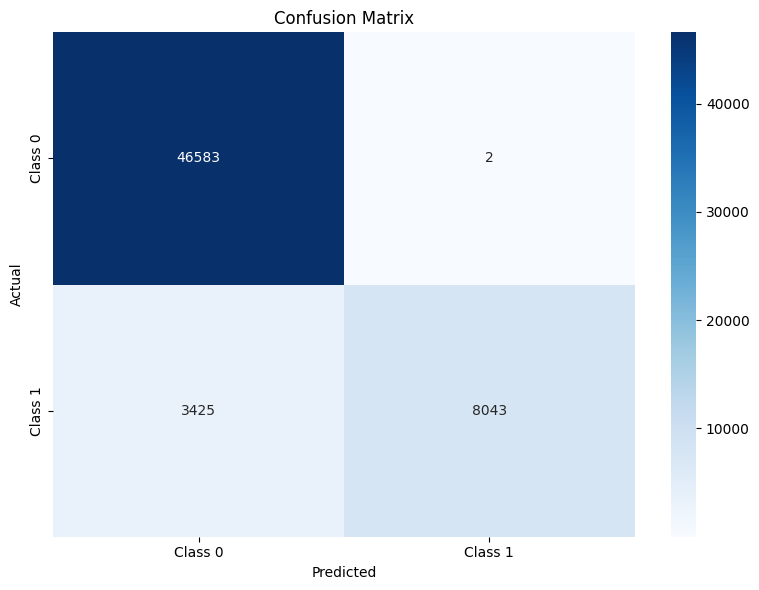

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # ✅ Make sure this is imported

print("🧩 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_lda)
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [ ]:
print("🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lda))

🧩 Confusion Matrix:
[[46583     2]
 [ 3425  8043]]


In [ ]:
#Step 3: Cross-Validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

cv_results = {metric: cross_val_score(LinearDiscriminantAnalysis(), X, y, cv=cv, scoring=scorer)
              for metric, scorer in scoring_metrics.items()}

print(f"\n🔁 {k}-Fold Cross-Validation Results (LDA):")
for metric, scores in cv_results.items():
    print(f"{metric.capitalize()} - Mean: {scores.mean():.4f}, Std Dev: {scores.std():.4f}")


🔁 5-Fold Cross-Validation Results (LDA):
Accuracy - Mean: 0.9414, Std Dev: 0.0007
Precision - Mean: 0.9453, Std Dev: 0.0006
Recall - Mean: 0.9414, Std Dev: 0.0007
F1 - Mean: 0.9373, Std Dev: 0.0008


<ipython-input-20-71f7a73fd64b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=lda_df, x='Target', y='LD1', palette='Set2', jitter=True, edgecolor='k')


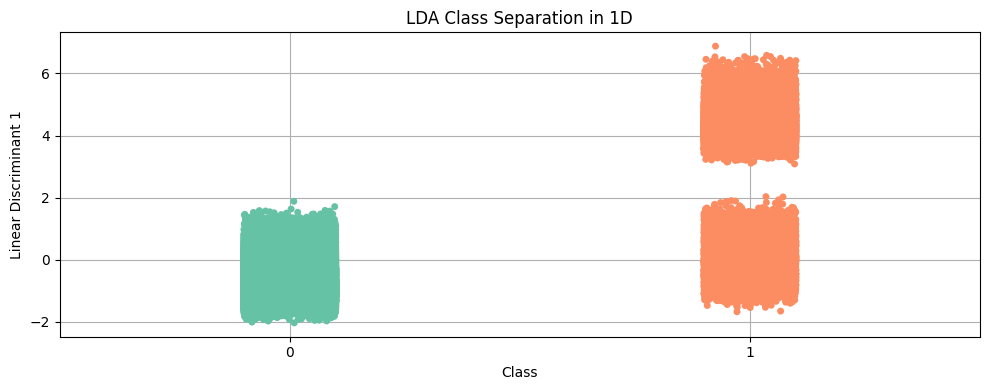

In [ ]:
# Use 1 component for binary classification
lda_vis = LinearDiscriminantAnalysis(n_components=1)
X_lda_1D = lda_vis.fit_transform(X, y)

lda_df = pd.DataFrame(data=X_lda_1D, columns=['LD1'])
lda_df['Target'] = y.values if hasattr(y, 'values') else y

plt.figure(figsize=(10, 4))
sns.stripplot(data=lda_df, x='Target', y='LD1', palette='Set2', jitter=True, edgecolor='k')
plt.title('LDA Class Separation in 1D')
plt.xlabel('Class')
plt.ylabel('Linear Discriminant 1')
plt.grid(True)
plt.tight_layout()
plt.show()
